In [4]:
import pandas as pd
import numpy as np

fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

fake["label"] = 0
true["label"] = 1

df = pd.concat([fake, true], axis=0)
df = df.sample(frac=1).reset_index(drop=True)

df.head()

,title,text,subject,date,label
0,"Trump notes Flynn lied to FBI, says his action...",WASHINGTON/NEW YORK (Reuters) - U.S. President...,politicsNews,"December 2, 2017",1
1,CBO estimates ending Obamacare mandate would i...,WASHINGTON (Reuters) - The U.S. Congressional ...,politicsNews,"November 8, 2017",1
2,U.S. tech firms urge presidential candidates t...,WASHINGTON (Reuters) - Thirteen U.S. industry ...,politicsNews,"May 4, 2016",1
3,"U.S. sanctions individuals, entities for Iran-...",WASHINGTON (Reuters) - The U.S. Treasury Depar...,worldnews,"November 20, 2017",1
4,NOT GRASSROOTS: #Ferguson Protestors PAID Over...,The Ferguson #BlackLivesMatter protesters are ...,politics,"May 17, 2015",0


In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df.isnull().sum()
df.dropna(inplace=True)

In [7]:
import re, string

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[%s]" % re.escape(string.punctuation), "", text)
    text = re.sub(
        "\d+", "", text)
    return text

df["text"] = df["text"].apply(clean_text)


In [8]:
df["text_length"] = df["text"].apply(len)
df["word_count"] = df["text"].apply(lambda x: len(x.split()))

In [9]:
Q1 = df["text_length"].quantile(0.25)
Q3 = df["text_length"].quantile(0.75)
IQR = Q3 - Q1

df = df[(df["text_length"] >= Q1 - 1.5*IQR) &
        (df["text_length"] <= Q3 + 1.5*IQR)]

In [10]:
df.shape
df.head()

,title,text,subject,date,label,text_length,word_count
0,"Trump notes Flynn lied to FBI, says his action...",washingtonnew york reuters us president donal...,politicsNews,"December 2, 2017",1,5279,874
1,CBO estimates ending Obamacare mandate would i...,washington reuters the us congressional budge...,politicsNews,"November 8, 2017",1,576,88
2,U.S. tech firms urge presidential candidates t...,washington reuters thirteen us industry group...,politicsNews,"May 4, 2016",1,3251,484
3,"U.S. sanctions individuals, entities for Iran-...",washington reuters the us treasury department...,worldnews,"November 20, 2017",1,1857,281
4,NOT GRASSROOTS: #Ferguson Protestors PAID Over...,the ferguson blacklivesmatter protesters are s...,politics,"May 17, 2015",0,1690,268


In [11]:
df.to_csv("cleaned_fake_news_dataset.csv", index=False)

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

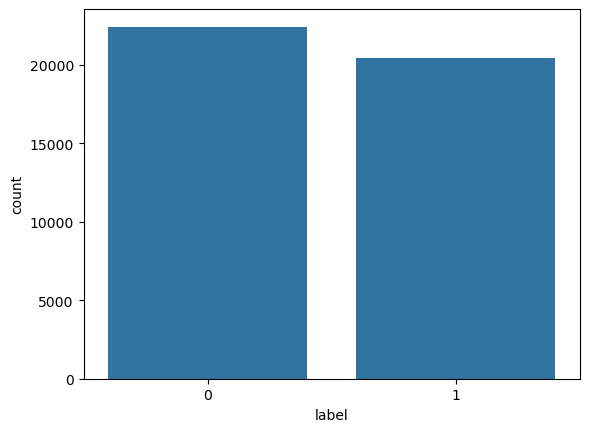

In [13]:
sns.countplot(x="label", data=df)
plt.show()

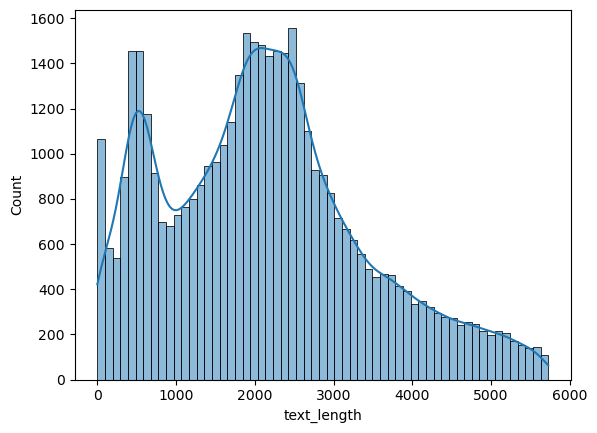

In [14]:
sns.histplot(df["text_length"], kde=True)
plt.show()

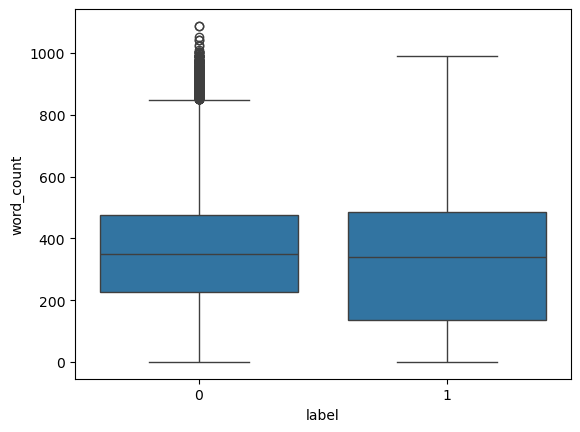

In [15]:
sns.boxplot(x="label", y="word_count", data=df)
plt.show()

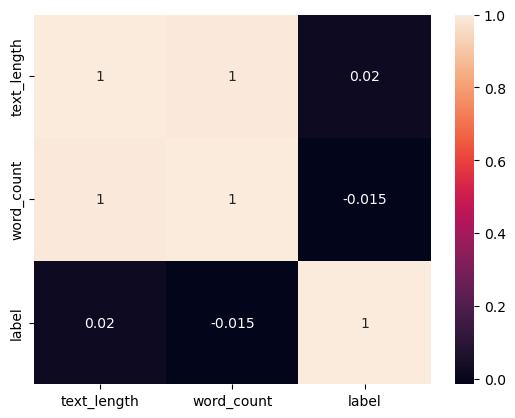

In [16]:
sns.heatmap(df[["text_length","word_count","label"]].corr(), annot=True)
plt.show()

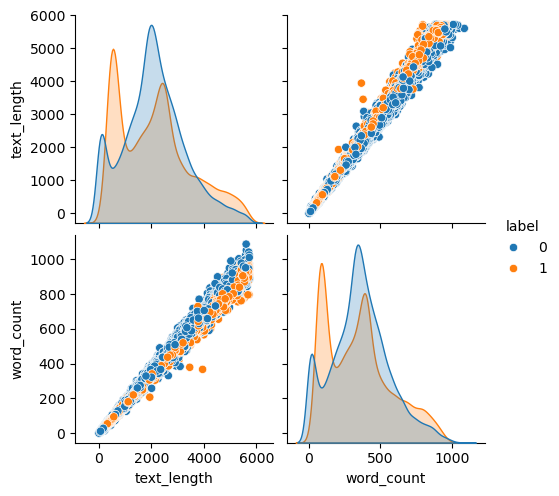

In [17]:
sns.pairplot(df[["text_length","word_count","label"]], hue="label")
plt.show()

In [18]:
df[["text_length","word_count"]].mean()
df[["text_length","word_count"]].median()
df[["text_length","word_count"]].var()
df[["text_length","word_count"]].mode()

,text_length,word_count
0,1,0


In [19]:
df[["text_length","word_count","label"]].corr()

,text_length,word_count,label
text_length,1.000000,0.995698,0.019500
word_count,0.995698,1.000000,-0.015471
label,0.019500,-0.015471,1.000000


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

X = df[["text_length","word_count"]]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

mae, rmse

(0.4328199638554498, np.float64(0.46227769582788575))

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words="english", max_df=0.7)
X_tfidf = tfidf.fit_transform(df["text"])

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df["label"], test_size=0.25)

log_model = LogisticRegression()
rf_model = RandomForestClassifier()

log_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

log_acc = accuracy_score(y_test, log_model.predict(X_test))
rf_acc = accuracy_score(y_test, rf_model.predict(X_test))

log_acc, rf_acc

(0.9814538676607643, 0.9863932898415657)

In [23]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

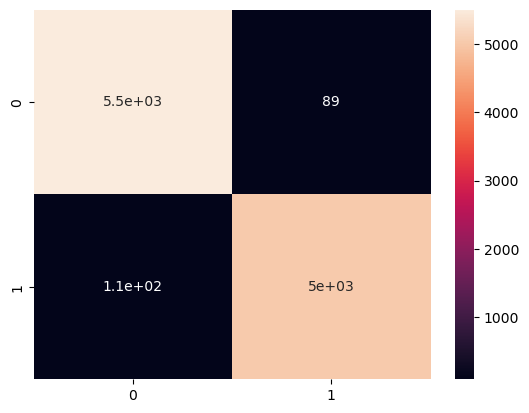

In [24]:
y_pred = log_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show()

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5591
           1       0.98      0.98      0.98      5139

    accuracy                           0.98     10730
   macro avg       0.98      0.98      0.98     10730
weighted avg       0.98      0.98      0.98     10730



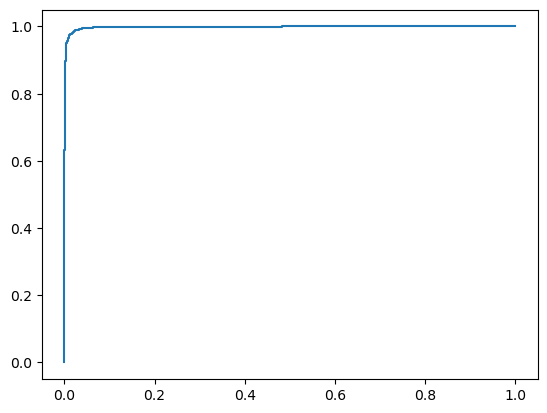

In [26]:
y_prob = log_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr)
plt.show()

In [28]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)

In [29]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_reduced)

df["cluster"] = clusters

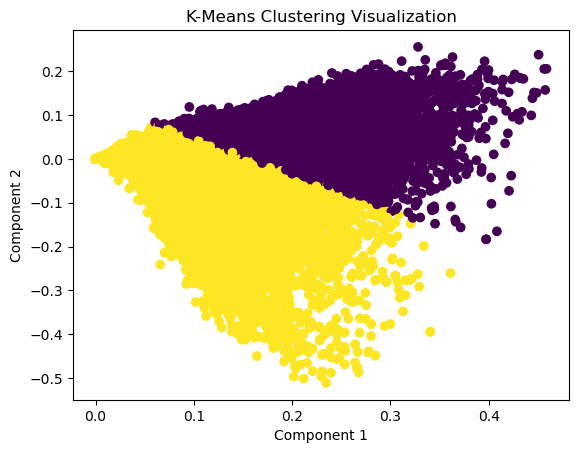

In [32]:
import matplotlib.pyplot as plt

plt.scatter(X_reduced[:,0], X_reduced[:,1], c=clusters, cmap="viridis")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("K-Means Clustering Visualization")
plt.show()

In [33]:
from sklearn.decomposition import TruncatedSVD

svd_ann = TruncatedSVD(n_components=100, random_state=42)

X_ann = svd_ann.fit_transform(X_tfidf)

In [34]:
from sklearn.model_selection import train_test_split

X_train_ann, X_test_ann, y_train_ann, y_test_ann = train_test_split(
    X_ann, df["label"], test_size=0.25, random_state=42
)

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

ann_model = Sequential([
    Input(shape=(X_train_ann.shape[1],)),
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
    Dense(1, activation="sigmoid")
])

ann_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [36]:
ann_model.fit(
    X_train_ann,
    y_train_ann,
    epochs=5,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/5
906/906 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9386 - loss: 0.2142 - val_accuracy: 0.9664 - val_loss: 0.0958
Epoch 2/5
906/906 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9652 - loss: 0.0917 - val_accuracy: 0.9680 - val_loss: 0.0926
Epoch 3/5
906/906 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9674 - loss: 0.0880 - val_accuracy: 0.9696 - val_loss: 0.0906
Epoch 4/5
906/906 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9682 - loss: 0.0860 - val_accuracy: 0.9680 - val_loss: 0.0878
Epoch 5/5
906/906 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9690 - loss: 0.0839 - val_accuracy: 0.9680 - val_loss: 0.0904


In [37]:
ann_loss, ann_acc = ann_model.evaluate(X_test_ann, y_test_ann)
ann_acc

336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9677 - loss: 0.0906  


0.9676607847213745

In [38]:
import pickle
pickle.dump(log_model, open("final_model.pkl", "wb"))
pickle.dump(tfidf, open("tfidf.pkl", "wb"))